In [12]:
import gym
import gym_anytrading
from gym_custom_trading import MyStockEnv
from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import STOCKS_GOOGL
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs
import pandas as pd
from stable_baselines import A2C
from stable_baselines.common.vec_env import DummyVecEnv


# Creating Environment

In [2]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()
window_size=30
start_index=window_size
end_index = len(df)


In [14]:
env_maker = lambda : MyStockEnv.MyStocksEnv(budget=1, df=df, window_size=window_size, frame_bound=(start_index, end_index))

env = DummyVecEnv([env_maker])

# Training model

In [15]:
policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1000)
model.save("a2c_googl_stocks2")


---------------------------------
| explained_variance | 0.031    |
| fps                | 8        |
| nupdates           | 1        |
| policy_entropy     | 1.09     |
| total_timesteps    | 5        |
| value_loss         | 20.6     |
---------------------------------
---------------------------------
| explained_variance | -0.00139 |
| fps                | 272      |
| nupdates           | 100      |
| policy_entropy     | 1.08     |
| total_timesteps    | 500      |
| value_loss         | 84.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000214 |
| fps                | 321       |
| nupdates           | 200       |
| policy_entropy     | 1.08      |
| total_timesteps    | 1000      |
| value_loss         | 58.6      |
----------------------------------


# Testing Environment

In [16]:
env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': -2260.4680668149977, 'total_profit': 407.0942999999999, 'position': 0}


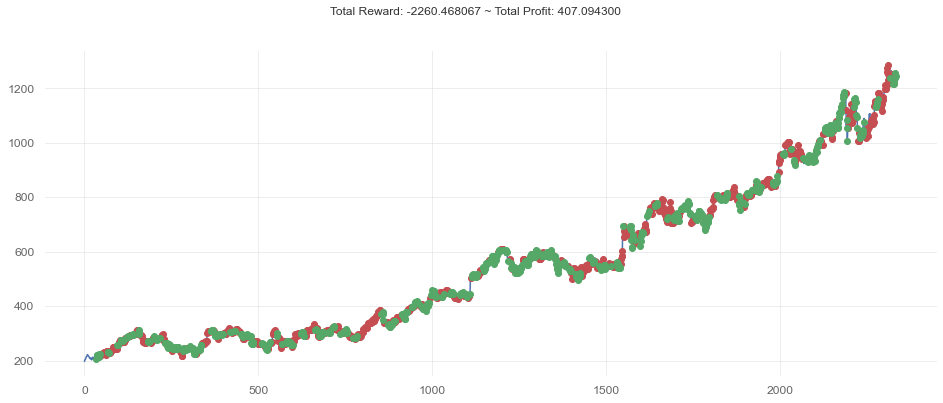

In [17]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

# Analysis using quantstats

                           Strategy
-------------------------  ----------
Start Period               2009-07-09
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             10.0%

Cumulative Return          40,609.43%
CAGR%                      -100.0%
Sharpe                     -5.12
Sortino                    -4.87
Max Drawdown               -236.68%
Longest DD Days            948
Volatility (ann.)          4424.75%
Calmar                     -1.0
Skew                       -2.78
Kurtosis                   5.73

Expected Daily %           -100.0%
Expected Monthly %         -100.0%
Expected Yearly %          -100.0%
Kelly Criterion            nan%
Risk of Ruin               1.0%
Daily Value-at-Risk        -57.49%
Expected Shortfall (cVaR)  -57.49%

Payoff Ratio               nan
Profit Factor              0.0
Common Sense Ratio         0.0
CPC Index                  nan
Tail Ratio                 0.0
Outlier Win Ratio          nan
Outlier Loss Ratio

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2010-01-08,2010-06-09,2010-08-04,208,-236.677572,-204.191775
2,2011-03-15,2013-01-14,2013-10-18,948,-174.664399,-165.840483
3,2009-09-02,2009-10-27,2009-12-14,103,-78.325476,-61.555001
4,2010-08-06,2010-08-27,2010-09-23,48,-77.460406,-68.847659
5,2014-10-13,2015-09-09,2016-01-22,466,-34.495693,-34.253076


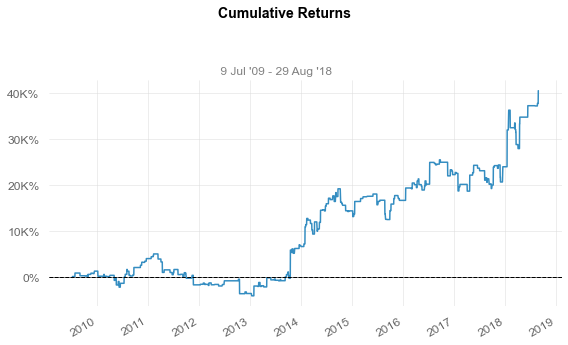

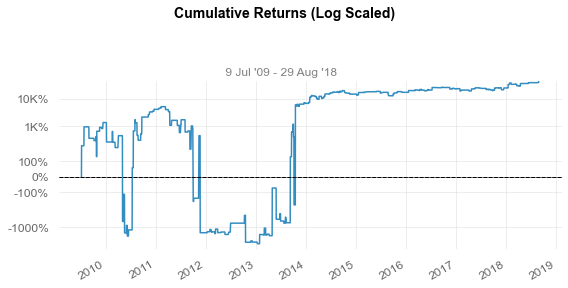

TypeError: 'method' object is not subscriptable

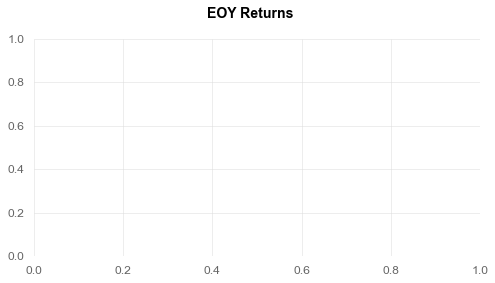

In [18]:

qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')